<a href="https://colab.research.google.com/github/Rinsworth/NDC-Project/blob/master/BERT_with_GPUs_NDC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Install packages

In [ ]:
!pip install transformers

In [ ]:
!pip install wandb --upgrade

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.28)


## Specify BERT version

In [ ]:
bert_version = 'bert-base-uncased'

## W&B Implementation


In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: erxiao (use `wandb login --relogin` to force relogin)


True

In [ ]:
%env WANDB_PROJECT = ndc-project
%env WANDB_LOG_MODEL = true 

env: WANDB_PROJECT=ndc-project
env: WANDB_LOG_MODEL=true


In [ ]:
lr = 9.0625e-5
batch_size = 8
epochs = 10
warmup_steps = 500
wandb_config = {
    'learning_rate': lr,
    'batch_size': batch_size,
    'epochs': epochs,
    'warmup_steps': warmup_steps
}
wandb.init(project='ndc-project', config=wandb_config, name=f'{lr}-lr_{batch_size}-batch_{epochs}-epochs_{warmup_steps}-warmups')

## Helper functions

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
def make_smart_batches(text_samples, labels, batch_size):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        max_len = 400

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_len,      # Do Truncate!
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels, batch_ordered_sentences, batch_ordered_labels)


# Data processing
(**MAKE SURE** to go on the left bar, click on 'Files', and upload the training data)

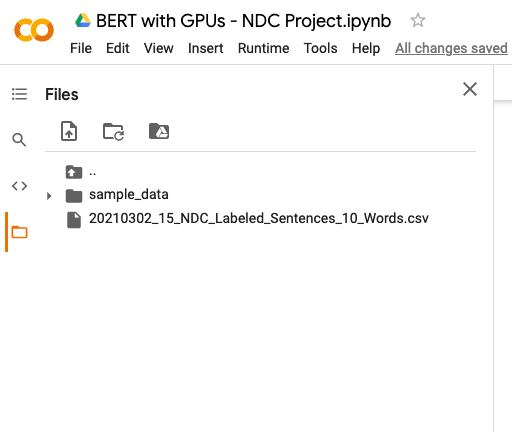

## Read data from file

In [ ]:
import pandas as pd
import numpy as np

data_dir = '20210302_15_NDC_Labeled_Sentences_10_Words.csv'

def load_data(data_dir):
  df = pd.read_csv(data_dir)
  df.drop(df[df['label'] == '_no_label'].index, inplace=True)   # drop unlabeled sentences

  # print('Labels:', np.unique(df['label']))
  # print('Countries:', np.unique(df['iso']))
  # print('# of countries:', len(np.unique(df['iso'])))

  return df

## Split into training and validation datasets

In [ ]:
# Divide set of countries into mutually exclusive train and test sets
from sklearn.model_selection import train_test_split

# mode to split by country or random
def split_train_test(df):
  # Split data into list of countries
  df_by_iso = list(df.groupby('iso'))
  train, test = train_test_split(df_by_iso, train_size=0.80)

  test, validation = train_test_split(test, test_size=0.50)

  # Print country statistics
  print(f'Training dataset contains {len(train)} countries, test dataset contains {len(test)} countries, and validation dataset contains {len(validation)} countries, for a total of {len(train) + len(test) + len(validation)} countries.')

  # Merge countries back into train and test datasets.
  # Each element of train/test is a tuple (iso, data), 
  # so grab data and respective column for each country.
  train_text        = np.concatenate([np.array(train[i][1]['sentence'])      for i in range(len(train))])
  train_labels      = np.concatenate([np.array(train[i][1]['label'])         for i in range(len(train))])
  test_text         = np.concatenate([np.array(test[i][1]['sentence'])       for i in range(len(test))])
  test_labels       = np.concatenate([np.array(test[i][1]['label'])          for i in range(len(test))])
  validation_text   = np.concatenate([np.array(validation[i][1]['sentence']) for i in range(len(validation))])
  validation_labels = np.concatenate([np.array(validation[i][1]['label'])    for i in range(len(validation))])

  # Sanity check
  assert len(train_text)      == len(train_labels)
  assert len(test_text)       == len(test_labels)
  assert len(validation_text) == len(validation_labels)

  # Print sentence statistics
  print(f'Training dataset contains {len(train_text)} sentences, test dataset contains {len(test_text)} sentences, and validation dataset contains {len(validation_text)} sentences, for a total of {len(train_text) + len(test_text) + len(validation_text)} sentences.')
  
  return (train_text, train_labels, test_text, test_labels, validation_text, validation_labels)

## Class balance visualization (optional)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

def see_train_dist(train_labels):
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.25)
  plt.rcParams["figure.figsize"] = (20,8)

  # Plot the number of tokens of each length.
  ax = sns.countplot(train_labels)
  # TODO: ^ same for test labels.

  # Add labels
  plt.title('Class Distribution')
  plt.xlabel('Category')
  plt.ylabel('# of Training Samples')

  # Add thousands separators to the y-axis labels.
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def see_test_dist(test_labels):
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.25)
  plt.rcParams["figure.figsize"] = (20,8)

  # Plot the number of tokens of each length.
  ax = sns.countplot(test_labels)
  # TODO: ^ same for test labels.

  # Add labels
  plt.title('Class Distribution')
  plt.xlabel('Category')
  plt.ylabel('# of Validation Samples')

  # Add thousands separators to the y-axis labels.
  import matplotlib as mpl
  ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

  plt.show()

## Encode labels from string to int

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(train_labels, val_labels, test_labels):
  encoder = LabelEncoder()
  encoder.fit(df['label'])

  train_labels = encoder.transform(train_labels)
  val_labels = encoder.transform(val_labels)
  test_labels = encoder.transform(test_labels)

  return (train_labels, val_labels, test_labels, encoder)

# Batching

## Load Tokenizer

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
# print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained(bert_version, do_lower_case=True)
# NOTE: moved to tokenize()

## Tokenize (no padding)

In [ ]:
def tokenize(train_text, bert_version):
  # Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained(bert_version, do_lower_case=True)

  max_len = 400

  full_input_ids = []
  labels = []

  # Tokenize all training examples
  print('Tokenizing {:,} training samples...'.format(len(train_text)))

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(train_text), num_desired_updates=10)

  # For each training example...
  for text in train_text:
      
      # Report progress.
      if ((len(full_input_ids) % update_interval) == 0):
          print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

      # Tokenize the sentence.
      input_ids = tokenizer.encode(text=text,           # Movie review text
                                  add_special_tokens=True, # Do add specials.
                                  max_length=max_len,  # Do truncate to `max_len`
                                  truncation=True,     # Do truncate!
                                  padding=False)       # Don't pad!
                                  
      # Add the tokenized result to our list.
      full_input_ids.append(input_ids)
      
  print('DONE.')
  print('{:>10,} samples'.format(len(full_input_ids)))

  return (full_input_ids, tokenizer)

## Unsorted data visualization (optional)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def see_unsorted_data(full_input_ids):
  # Get all of the lengths.
  unsorted_lengths = [len(x) for x in full_input_ids]

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

  plt.xlabel('Sample Number')
  plt.ylabel('Sequence Length')
  plt.title('Samples BEFORE Sorting')

  plt.show()

## Sort data

In [ ]:
def sort_data(full_input_ids, train_labels):
  # Sort the two lists together by the length of the input sequence.
  train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))
  train_samples[0]
  print('Shortest sample:', len(train_samples[0][0]))
  print('Longest sample:', len(train_samples[-1][0]))

  return train_samples

## Sorted data visualization (optional)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def see_sorted_data(train_samples):
  # Get the new list of lengths after sorting.
  sorted_lengths = [len(s[0]) for s in train_samples]

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

  plt.xlabel('Sample Number')
  plt.ylabel('Sequence Length')
  plt.title('Samples after Sorting')

  plt.show()

## Random batch selection

### Choose batch size

In [ ]:
# batch_size = wandb.config.batch_size
# NOTE: moved to select_batches()

### Selection algorithm information

Rather than dividing the batches up in order, we will still add a degree of **randomness** to our selection.

Here's the process:

1.   Pick a random starting point in the (sorted) list of samples.
2.   Grab a contiguous batch of samples starting from that point.
3.   Delete those samples from the list, and repeat until all of the samples have been grabbed.

This will result in some **fragmentation** of the list, which means it won't be quite as efficient as if we just sliced up the batches in sorted order.

The benefit is that our path through the training set can still have a degree of randomness. 



### Perform batch selection

In [ ]:
import random

def select_batches(train_samples):
  batch_size = wandb.config.batch_size
  # List of batches that we'll construct.
  batch_ordered_sentences = []
  batch_ordered_labels = []

  print('Creating training batches of size {:}'.format(batch_size))

  # Loop over all of the input samples...    
  while len(train_samples) > 0:
      
      # Report progress.
      if ((len(batch_ordered_sentences) % 500) == 0):
          print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

      # `to_take` is our actual batch size. It will be `batch_size` until 
      # we get to the last batch, which may be smaller. 
      to_take = min(batch_size, len(train_samples))

      # Pick a random index in the list of remaining samples to start
      # our batch at.
      select = random.randint(0, len(train_samples) - to_take)

      # Select a contiguous batch of samples starting at `select`.
      batch = train_samples[select:(select + to_take)]

      # Each sample is a tuple--split them apart to create a separate list of 
      # sequences and a list of labels for this batch.
      batch_ordered_sentences.append([s[0] for s in batch])
      batch_ordered_labels.append([s[1] for s in batch])

      # Remove these samples from the list.
      del train_samples[select:select + to_take]

  print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

  return (batch_size, batch_ordered_sentences, batch_ordered_labels)

## Add padding

In [ ]:
import torch

def add_padding(batch_ordered_sentences, batch_ordered_labels, tokenizer):
  py_inputs = []
  py_attn_masks = []
  py_labels = []

  # For each batch...
  for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

      # New version of the batch, this time with padded sequences and now with
      # attention masks defined.
      batch_padded_inputs = []
      batch_attn_masks = []
      
      # First, find the longest sample in the batch. 
      # Note that the sequences do currently include the special tokens!
      max_size = max([len(sen) for sen in batch_inputs])

      #print('Max size:', max_size)

      # For each input in this batch...
      for sen in batch_inputs:
          
          # How many pad tokens do we need to add?
          num_pads = max_size - len(sen)

          # Add `num_pads` padding tokens to the end of the sequence.
          padded_input = sen + [tokenizer.pad_token_id]*num_pads

          # Define the attention mask--it's just a `1` for every real token
          # and a `0` for every padding token.
          attn_mask = [1] * len(sen) + [0] * num_pads

          # Add the padded results to the batch.
          batch_padded_inputs.append(padded_input)
          batch_attn_masks.append(attn_mask)

      # Our batch has been padded, so we need to save this updated batch.
      # We also need the inputs to be PyTorch tensors, so we'll do that here.
      py_inputs.append(torch.tensor(batch_padded_inputs))
      py_attn_masks.append(torch.tensor(batch_attn_masks))
      py_labels.append(torch.tensor(batch_labels))

  return (py_inputs, py_attn_masks, py_labels)

## Padding visualization (optional)

In [ ]:
def see_padding(py_inputs, train_text):
  # Get the new list of lengths after sorting.
  padded_lengths = []

  # For each batch...
  for batch in py_inputs:
      
      # For each sample...
      for s in batch:
      
          # Record its length.
          padded_lengths.append(len(s))

  # Sum up the lengths to the get the total number of tokens after smart batching.
  smart_token_count = np.sum(padded_lengths)

  # To get the total number of tokens in the dataset using fixed padding, it's
  # as simple as the number of samples times our `max_len` parameter (that we
  # would pad everything to).
  fixed_token_count = len(train_text) * max_len

  # Calculate the percentage reduction.
  prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

  print('Total tokens:')
  print('   Fixed Padding: {:,}'.format(fixed_token_count))
  print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


# Training

## Load pre-trained model

In [ ]:
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
import torch

def load_model(bert_version):
  config = AutoConfig.from_pretrained(pretrained_model_name_or_path=bert_version, num_labels=11)

  print('Config type:', str(type(config)), '\n')
  print(config)

  model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=bert_version, config=config)

  print('\nModel type:', str(type(model)))

  print('\nLoading model to GPU...')
  device = torch.device('cuda')
  print('   GPU:', torch.cuda.get_device_name(0))
  desc = model.to(device)
  print('   DONE.')

  return (model, device)

## Optimizer and Learning Rate scheduler

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def get_optimizer_scheduler(model, py_inputs):
  optimizer = AdamW(model.parameters(), lr=wandb.config.learning_rate, eps=1e-8)
  
  epochs = wandb.config.epochs

  total_steps = len(py_inputs) * epochs

  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=wandb.config.warmup_steps, num_training_steps=total_steps)

  return (optimizer, scheduler, epochs)

def get_learning_rate(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

## Training Loop

In [ ]:
import random
import numpy as np

def train_loop(model, py_inputs, py_attn_masks, py_labels, epochs, train_text, train_labels, batch_size, device, optimizer, scheduler, encoder):
  # randomize and record
  seed_val = 321

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  total_t0 = time.time()

  global_step = 0
  num_val_inc = 0
  prev_val_acc = 0
  max_val_acc = 0
  VAL_STOP = 3

  wandb.log({'learning_rate':get_learning_rate(optimizer)}, step=global_step)
  wandb.log({'training accuracy': 1/11}, step=global_step)
  wandb.log({'validation accuracy': 1/11}, step=global_step)

  for epoch_i in range(epochs):
    print("")
    print(f"{'='*8} Epoch {epoch_i+1} / {epochs} {'='*8}")

    if epoch_i > 0:
      (py_inputs, py_attn_masks, py_labels, _, _) = make_smart_batches(train_text, train_labels, batch_size)
    
    print(f"Training on {len(py_inputs)} batches...")

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step in range(len(py_inputs)):
      global_step += 1

      if step % update_interval == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)

        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        print(f"    Batch {step} of {len(py_inputs)}.   Elapsed: {elapsed}.   Remaining: {remaining}")

      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      model.zero_grad()
      
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      wandb.log({'train_batch_loss':outputs.loss.item()}, step=global_step)

      total_train_loss += outputs.loss

      outputs.loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      wandb.log({'learning_rate':get_learning_rate(optimizer)}, step=global_step)

      scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)

    training_time = format_time(time.time() - t0)

    # eval loop
    train_preds, train_true_labels, _, _, _ = eval_model(model, train_text, train_labels, batch_size, device)
    val_preds, val_true_labels, _, _, val_loss = eval_model(model, validation_text, validation_labels, batch_size, device)

    # print val accuracy
    print_accuracy(train_preds, train_true_labels, encoder, step=global_step, title='training')
    val_acc = print_accuracy(val_preds, val_true_labels, encoder, step=global_step, title='validation')

    # save best model
    if val_acc > max_val_acc:
      max_val_acc = val_acc
      torch.save(model.state_dict(), 'best_model.pt')

    wandb.log({'train_epoch_loss':avg_train_loss}, step=global_step)
    wandb.log({'validation_epoch_loss':val_loss}, step=global_step)

    print("")
    print("   Average training loss: {0:.2f}".format(avg_train_loss))
    print("   Average validation loss: {0:.2f}".format(val_loss))
    print(f"   Training epoch took: {training_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'Validation Loss': val_loss
        }
    )

# Evaluation

## Smart-batch testing dataset

In [ ]:
# Use our new function to completely prepare our dataset.
# (py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_text, test_labels, batch_size)
# NOTE: moved to eval_model()

## Evaluate model

In [ ]:
def eval_model(model, test_text, test_labels, batch_size, device):
  # Prediction on test set
  # Refactor to eval_loop(model, data)

  (py_inputs, py_attn_masks, py_labels, batch_ordered_sentences, batch_ordered_labels) = make_smart_batches(test_text, test_labels, batch_size)

  print('Predicting labels for {:,} test sentences...'.format(len(test_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  total_loss = 0

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)
          
          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)
    
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask, labels=b_labels)

      logits = outputs[1] # used to be 0, should be 1 or try .logits?
      total_loss += outputs.loss.item()

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
    
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

  avg_loss = total_loss / step

  print('    DONE.')
  return (predictions, true_labels, batch_ordered_sentences, batch_ordered_labels, avg_loss)

### Print accuracy

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
def print_accuracy(predictions, true_labels, encoder, step=None, title=None):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()
  # sample k errors to find pattern

  # use sklearn.metrics.f1_score here, get average f1 use macro, per class f1 pass in None to average
  # use sklearn.metrics.confusion_matrix here, plot into wandb
  # calculate f1 and confusion on train and val, compare train to val

  #f1_per_class = f1_score(true_labels, preds, average=None)

  if step is not None:
    if title is not None:
      wandb.log({title + ' accuracy': accuracy}, step=step)
      f1_average = f1_score(true_labels, preds, average='macro')
      wandb.log({title + ' f1_average': f1_average}, step=step)
      wandb.log({title + ' confusion matrix': wandb.plot.confusion_matrix(probs=None,
                                                                          y_true=true_labels, preds=preds,
                                                                          class_names=encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))},
                step=step)

  # print('Accuracy: {:.3f}'.format(accuracy))
  # print('F1: {:.3f}'.format(f1))
  return accuracy
  

# Main

In [ ]:
if __name__ == "__main__":
  df = load_data(data_dir)
  train_text, train_labels, test_text, test_labels, validation_text, validation_labels = split_train_test(df)
  # see_train_dist(train_labels)
  train_labels, validation_labels, test_labels, encoder = encode_labels(train_labels, validation_labels, test_labels)
  full_input_ids, tokenizer = tokenize(train_text, bert_version)
  # see_unsorted_data(full_input_ids)
  train_samples = sort_data(full_input_ids, train_labels)
  # see_sorted_data(train_samples)
  batch_size, batch_ordered_sentences, batch_ordered_labels = select_batches(train_samples)
  py_inputs, py_attn_masks, py_labels = add_padding(batch_ordered_sentences, batch_ordered_labels, tokenizer)
  # see_padding(py_inputs, train_text)
  model, device = load_model(bert_version)
  optimizer, scheduler, epochs = get_optimizer_scheduler(model, py_inputs)
  train_loop(model, py_inputs, py_attn_masks, py_labels, epochs, train_text, train_labels, batch_size, device, optimizer, scheduler, encoder)
  # clear and load best model
  # model.load_state_dict(torch.load("best_model.pt"))
  model.to(device)
  predictions, true_labels, bos, bol, _ = eval_model(model, validation_text, validation_labels, batch_size, device)
  val_accuracy = print_accuracy(predictions, true_labels, encoder)
  print('Best Val Accuracy: {:.3f}'.format(val_accuracy))

Training dataset contains 85 countries, test dataset contains 11 countries, and validation dataset contains 11 countries, for a total of 107 countries.
Training dataset contains 12267 sentences, test dataset contains 969 sentences, and validation dataset contains 1059 sentences, for a total of 14295 sentences.
Loading BERT tokenizer...
Tokenizing 12,267 training samples...
  Tokenized 0 samples.
  Tokenized 1,000 samples.
  Tokenized 2,000 samples.
  Tokenized 3,000 samples.
  Tokenized 4,000 samples.
  Tokenized 5,000 samples.
  Tokenized 6,000 samples.
  Tokenized 7,000 samples.
  Tokenized 8,000 samples.
  Tokenized 9,000 samples.
  Tokenized 10,000 samples.
  Tokenized 11,000 samples.
  Tokenized 12,000 samples.
DONE.
    12,267 samples
Shortest sample: 11
Longest sample: 397
Creating training batches of size 8
  Selected 0 batches.
  Selected 500 batches.
  Selected 1,000 batches.
  Selected 1,500 batches.

  DONE - 1,534 batches.
Config type: <class 'transformers.models.bert.conf

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Model type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>

Loading model to GPU...
   GPU: Tesla T4
   DONE.

======== Epoch 1 / 10 ========
Training on 1534 batches...
    Batch 200 of 1534.   Elapsed: 0:00:19.   Remaining: 0:02:04
    Batch 400 of 1534.   Elapsed: 0:00:39.   Remaining: 0:01:49
    Batch 600 of 1534.   Elapsed: 0:00:58.   Remaining: 0:01:31
    Batch 800 of 1534.   Elapsed: 0:01:18.   Remaining: 0:01:12
    Batch 1000 of 1534.   Elapsed: 0:01:37.   Remaining: 0:00:52
    Batch 1200 of 1534.   Elapsed: 0:01:57.   Remaining: 0:00:32
    Batch 1400 of 1534.   Elapsed: 0:02:16.   Remaining: 0:00:13
Creating Smart Batches from 12,267 examples with batch size 8...

Tokenizing 12,267 samples...
  Tokenized 0 samples.
  Tokenized 1,000 samples.
  Tokenized 2,000 samples.
  Tokenized 3,000 samples.
  Tokenized 4,000 samples.
  Tokenized 5,000 samples.
  Tokenized 6,000 samples.
  Tokenized 7,000 samples.
  Tokenized 8,000 samples.
  Tokenized 